In [2]:
!pip install h5netcdf

In [1]:
#Load modules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Image
import scipy.io
import pandas as pd
from IPython.display import display, clear_output
import sys, os
import warnings
import h5py

warnings.filterwarnings('ignore')

from sklearn.mixture import GaussianMixture
from scipy import linalg
import itertools
import seaborn as sns


from sklearn.cluster import SpectralClustering, AffinityPropagation



%matplotlib inline

from aidapy import load_data
import aidapy.aidaxr

In [2]:
from h5utils import h5tovts

ModuleNotFoundError: No module named 'h5utils'

In [3]:
#Choose download times
# start_time = datetime(2015, 10, 16, 13, 7, 0);
# end_time   = datetime(2015, 10, 16, 13, 9, 0);
# start_time = datetime(2017, 7, 3, 5, 26, 50)
# end_time   = datetime(2017, 7, 3, 5, 26, 51,2)
start_time = datetime(2015, 10, 16, 13, 7, 0);
end_time   = datetime(2015, 10, 16, 13, 8, 0);
# start_time = datetime(2015, 9, 19, 7, 42,19 )
# end_time   = datetime(2015, 9, 19, 7, 55, 41)
# start_time = datetime(2017, 5, 27, 7, 42, 20)
# end_time   = datetime(2017, 5, 27, 7, 44, 40)
starttime=[start_time.year,start_time.month, start_time.day, start_time.hour, start_time.minute]

# start_time_sub = datetime(start_time.year, start_time.month, start_time.day, 13, 7, 2, 100000);
# end_time_sub   = datetime(start_time.year, start_time.month, start_time.day, 13, 7, 5, 130000);
# start_time_sub = datetime(start_time.year, start_time.month, start_time.day, start_time.hour,43, 35,250000)
# end_time_sub   = datetime(start_time.year, start_time.month, start_time.day, start_time.hour, 43, 35, 280000)

#Select probe(s)
probes= ['3']
probes2= 3

In [4]:
settings = {'prod': ['i_dist', 'e_dist', 'dc_mag', 'sc_att', 'i_bulkv'],
            'probes': ['3'], 'coords': 'gse', 'mode': 'high_res', 'frame':'gse'};
species      = 'electron'
frame        = 'B'
grid_geom     = 'cart'
v_max        = 1.2e7
resolution   = 25
interp_schem = 'lin'
#Load the mms data
xr_mms = load_data(mission='mms', start_time=start_time, end_time=end_time, **settings);

In [5]:
xr_mms

<xarray.Dataset>
Dimensions:                   (time1: 293, mms3_dis_energy_brst: 32,
                               mms3_dis_theta_brst: 16, mms3_dis_phi_brst: 32,
                               time2: 1465, mms3_des_energy_brst: 32,
                               mms3_des_theta_brst: 16, mms3_des_phi_brst: 32,
                               time3: 5609, mms3_fgm_b_gse_brst_l2: 4,
                               time4: 3, mms3_mec_quat_eci_to_gse: 4,
                               time5: 293, mms3_dis_bulkv_gse_brst: 3)
Coordinates: (12/14)
  * time1                     (time1) datetime64[ns] 2015-10-16T13:07:00.0218...
  * mms3_dis_energy_brst      (mms3_dis_energy_brst) float32 12.06 ... 2.83e+04
  * mms3_dis_theta_brst       (mms3_dis_theta_brst) float32 5.625 ... 174.4
  * mms3_dis_phi_brst         (mms3_dis_phi_brst) float32 5.813 17.06 ... 354.6
  * time2                     (time2) datetime64[ns] 2015-10-16T13:07:00.0218...
  * mms3_des_energy_brst      (mms3_des_energy_brst) float32 12.41 ... 2.759e+04
    ...                        ...
  * time3                     (time3) datetime64[ns] 2015-10-16T13:07:00.0076...
  * mms3_fgm_b_gse_brst_l2    (mms3_fgm_b_gse_brst_l2) <U3 'x' 'y' 'z' 'tot'
  * time4                     (time4) datetime64[ns] 2015-10-16T13:07:00 ... ...
  * mms3_mec_quat_eci_to_gse  (mms3_mec_quat_eci_to_gse) <U3 'x' 'y' 'z' 'tot'
  * time5                     (time5) datetime64[ns] 2015-10-16T13:07:00.0218...
  * mms3_dis_bulkv_gse_brst   (mms3_dis_bulkv_gse_brst) <U1 'x' 'y' 'z'
Data variables:
    i_dist3                   (time1, mms3_dis_energy_brst, mms3_dis_theta_brst, mms3_dis_phi_brst) float32 ...
    e_dist3                   (time2, mms3_des_energy_brst, mms3_des_theta_brst, mms3_des_phi_brst) float32 ...
    dc_mag3                   (time3, mms3_fgm_b_gse_brst_l2) float32 12.81 ....
    sc_att3                   (time4, mms3_mec_quat_eci_to_gse) float64 -0.03...
    i_bulkv3                  (time5, mms3_dis_bulkv_gse_brst) float32 -203.4...
Attributes:
    mission:        mms
    load_settings:  {'prod': ['i_dist', 'e_dist', 'dc_mag', 'sc_att', 'i_bulk...

In [8]:
#The build in interpolation function of Aidapy

# xr_mms = xr_mms.vdf.interpolate(start_time, end_time, start_time_sub, end_time_sub,
#                         species=species, frame=frame, grid_geom=grid_geom,
#                         v_max=v_max, resolution=resolution, interp_schem=interp_schem);
# vdf=xr_mms['vdf_interp'].values;

#f = h5py.File('C:/Users/natha/aidapy/vdfstorage/vdf'+str(starttime)+'.hdf5','w')
# group = f.create_group('b_group')
#f.create_dataset('vdf'+str(starttime),data=vdf)
#f.close()

NameError: name 'start_time_sub' is not defined

vxv -2280.197 2280.197
vyv -2280.1968 2280.1968
vzv -2288.0552 2288.0552


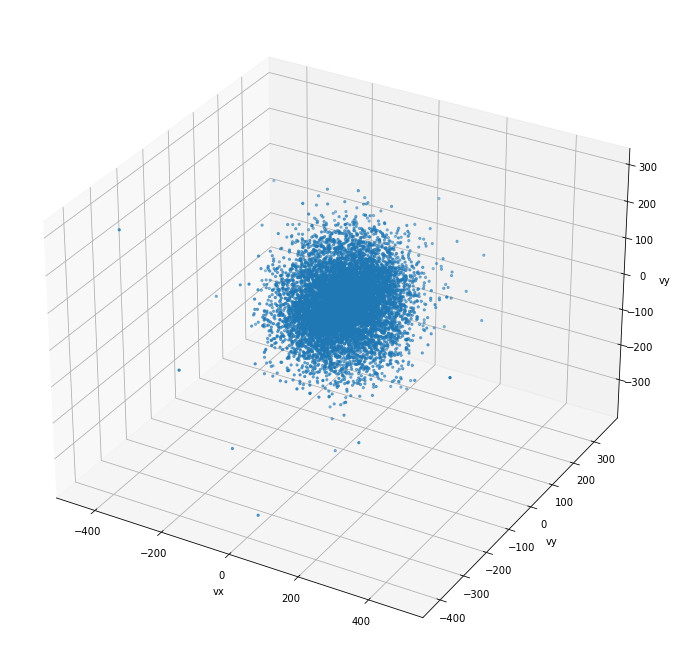

In [7]:
#Manual interpolation of the MMS-VDF data

#these 4 lines are only to save time when you change probe from aidapy 

phistr='mms{}_des_phi_brst'.format(probes2)
thetastr='mms{}_des_theta_brst'.format(probes2)
energystr='mms{}_des_energy_brst'.format(probes2)
fpistr='e_dist{}'.format(probes2)

#so you convert from th-ph-enrg to vx-vy-vz and interpolate over a rectangular grid

vmax = 560 #electron parameters
mi = 1.67e-27
e = 0.5*mi*(vmax*1e3)**2
e = e/(1.6e-19)

phi=np.array(xr_mms[phistr]/360*2*np.pi)
theta=np.array(xr_mms[thetastr]/360*2*np.pi)
energy=np.array(xr_mms[energystr])

v =np.sqrt(2/mi*energy*(1.6e-19)) *1e-3
fpi=np.array(xr_mms[fpistr])

fiv, thv, vv = np.meshgrid(phi, theta, v,  indexing='ij')
vxv = vv * np.cos (fiv) * np.sin (thv)
vyv = vv * np.sin (fiv) * np.sin (thv)
vzv = vv * np.cos (thv)

print('vxv',np.min(vxv),np.max(vxv))
print('vyv',np.min(vyv),np.max(vyv))
print('vzv',np.min(vzv),np.max(vzv))

points=np.column_stack((vxv.ravel(), vyv.ravel(), vzv.ravel()))
vx = np.linspace(-vmax, vmax, 100)

grid_x, grid_y, grid_z= np.meshgrid(vx,vx,vx, indexing='ij')
Nx,Ny,Nz= grid_x.shape
Ntimes=fpi.shape[0]
fpicart=np.zeros((Ntimes,Nx,Ny,Nz))
tim=200
fpi1=fpi[tim,:].ravel()
fpicart[tim,:,:,:]  = scipy.interpolate.griddata(points, fpi1, (grid_x, grid_y, grid_z), method='linear')
vdf=fpicart[tim,:,:,:] 
nx,ny,nz=vdf.shape

vmax=560
dv= 2*vmax/(nx-1)
v1D= np.arange(-vmax,vmax+dv,dv)
vvx,vvy,vvz= np.meshgrid(v1D,v1D,v1D)
Np=10000 #Number of particles generated from VDF
vvx.shape, vdf.shape

f1D=vdf.flatten()
fmin= min([i for i in f1D if i>0])

f1D= np.where(f1D==0, fmin/1000, f1D)

vx1D=(np.conjugate(vvx).T).flatten()
vy1D=(np.conjugate(vvy).T).flatten()
vz1D=(np.conjugate(vvz).T).flatten()

Ng=f1D.shape[0]
ranarr=np.random.rand(4,Np)
fcum=np.cumsum(f1D);

fcum=Ng*fcum/fcum[Ng-1]

NgRange=np.arange(1,Ng+1)

Pg=np.interp(Ng*ranarr[0,:], fcum.T, NgRange)
Pg= 1 + np.floor(Pg)
Pg=Pg.astype(int)

xp=vx1D[Pg] + dv*ranarr[1,:] - dv/2
yp=vy1D[Pg] + dv*ranarr[2,:] - dv/2
zp=vz1D[Pg] + dv*ranarr[3,:] - dv/2

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

scat=ax.scatter(xp,yp,zp, marker='.')
ax.set_xlabel('vx')
ax.set_ylabel('vy')
ax.set_zlabel('vy')
fcmdata=np.array([xp,yp,zp])
fcmdata=np.conjugate(fcmdata).T


In [9]:
#Code to display VDF crossections if Aidapy build-in interpolation was used

# resolution = vdf.shape[0]
# cmap='RdBu_r'
# ind_mid = int(resolution/2.)
# centers_x = xr_mms['grid_interp_cart'][0, :, 0, 0]
# dX = centers_x[1]-centers_x[0]
# edges_x = centers_x-.5*dX
# edges_x = np.append(edges_x, edges_x[-1]+dX)
# x = centers_x
# y = centers_x

# a0 = np.log10(vdf[:, :, ind_mid])
# a1 = np.log10(vdf[:, ind_mid, :])
# a2 = np.log10(vdf[ind_mid, :, :])

# vlima = max(np.nanmax(a0), np.nanmax(a1), np.nanmax(a2))

# fig, AX = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
# plt.subplots_adjust(top=.99, bottom=.03, left=.03, right=.99,
#                         wspace=0., hspace=0.)
# for ax in AX.flatten():
#     ax.set_aspect('equal')
    
# m0 = AX[0].pcolormesh(edges_x, edges_x, a0.T,
#                               vmax=vlima, #vmin=-vlima,
#                               cmap=cmap, rasterized=True)
#                               # vmax=vlim,
#                           # vmin=-16.5,vmax=-11.8,
# AX[1].pcolormesh(edges_x, edges_x, a1.T,
#                          vmax=vlima, #vmin=-vlima,
#                          cmap=cmap, rasterized=True)
#                          # vmax=vlim,
#                          # vmin=-16.5,vmax=-11.8,
# AX[2].pcolormesh(edges_x, edges_x, a2.T,
#                          vmax=vlima, #vmin=-vlima,
#                          cmap=cmap, rasterized=True)
#                          # vmax=vlim,
#                          # vmin=-16.5,vmax=-11.8,


# AX[0].contour(x, y, a0.T, levels=40, colors='k', linewidths=.5)
# AX[1].contour(x, y, a1.T, levels=40, colors='k', linewidths=.5)
# AX[2].contour(x, y, a2.T, levels=40, colors='k', linewidths=.5)

# posAx = AX[1].get_position()
# cax = fig.add_axes([posAx.x0*1.1, posAx.y0*.55, .2, 0.015])
# cb = fig.colorbar(m0, cax=cax, orientation='horizontal')
# cb.set_label('VDF (s^3/m^6)')
# AX[0].set_title('v_x, v_y')
# AX[1].set_title('v_x, v_z')
# AX[2].set_title('v_y, v_z')

# fig.suptitle('Cartesian coordinate system, cuts')   
# plt.show()   

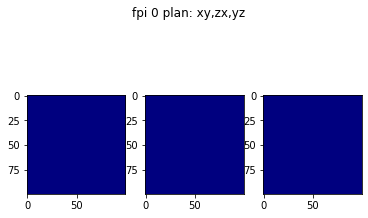

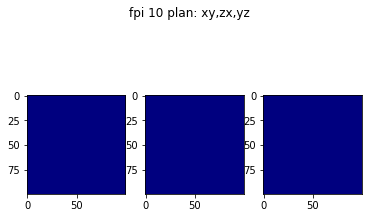

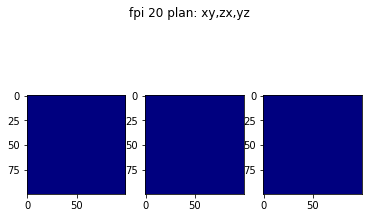

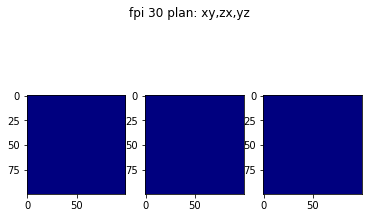

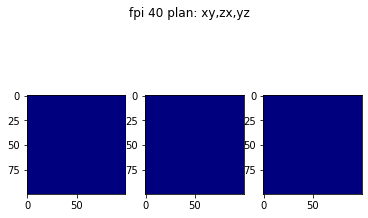

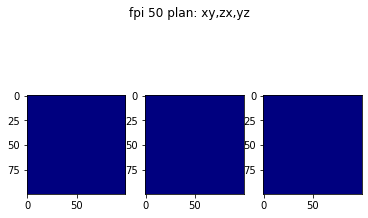

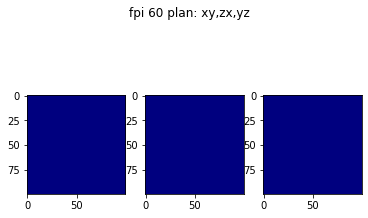

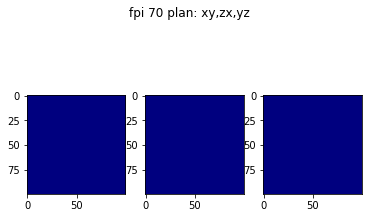

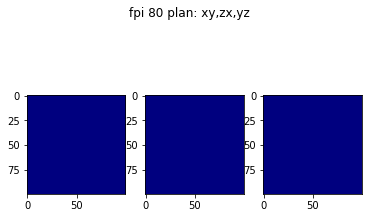

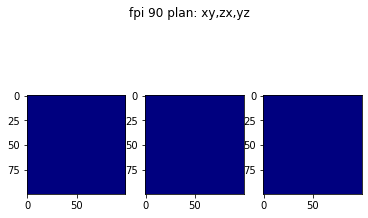

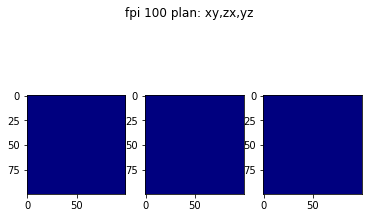

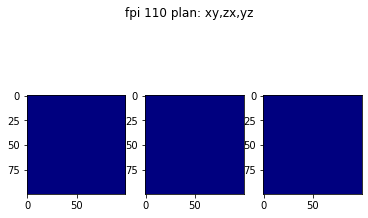

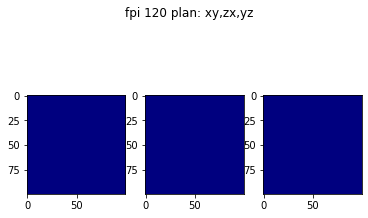

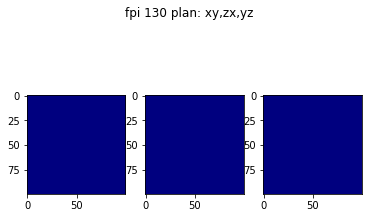

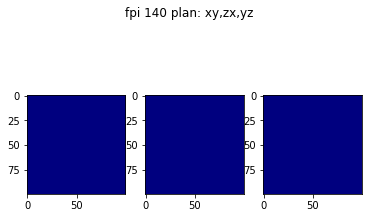

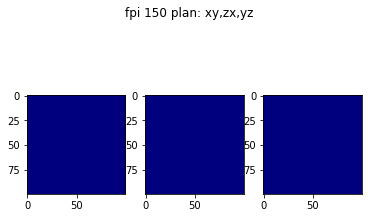

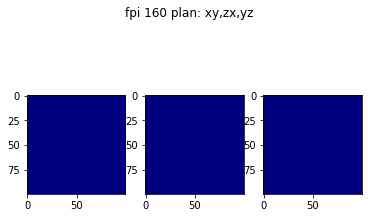

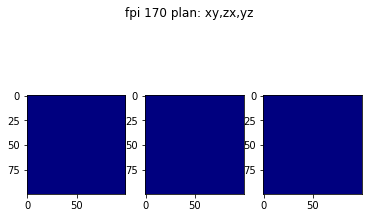

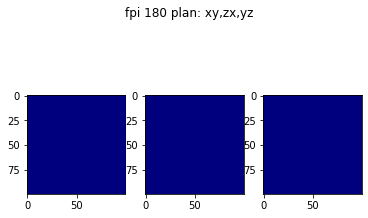

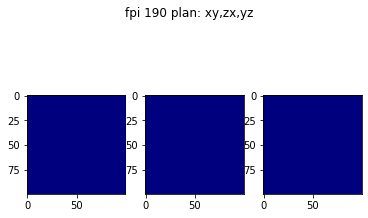

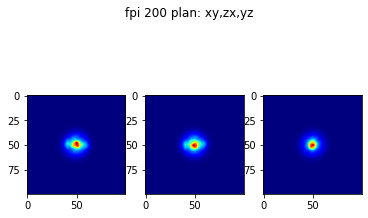

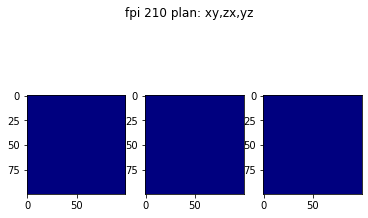

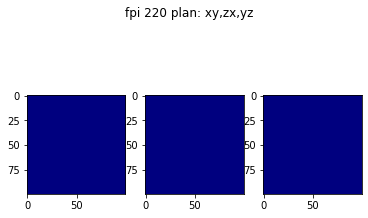

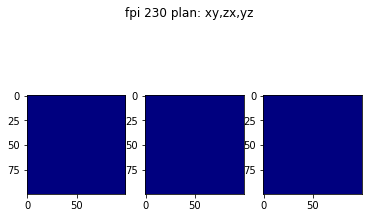

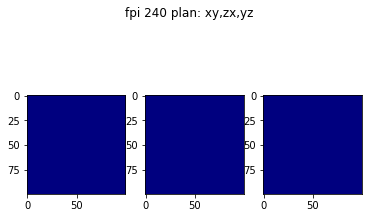

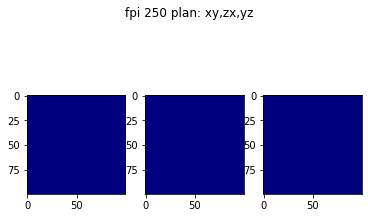

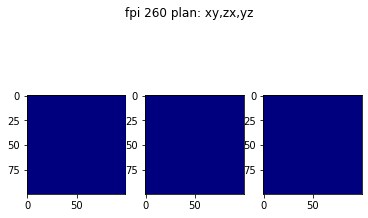

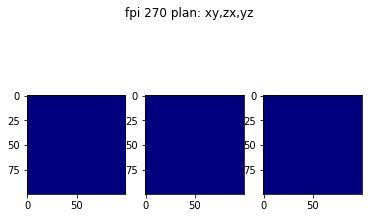

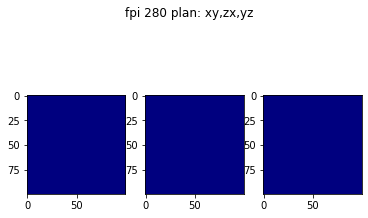

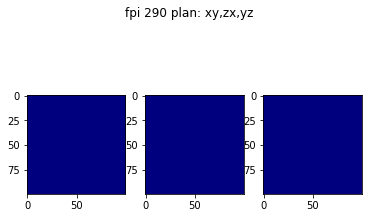

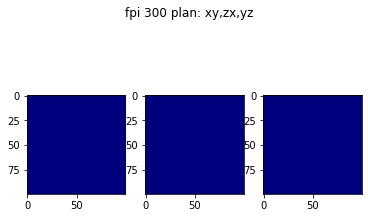

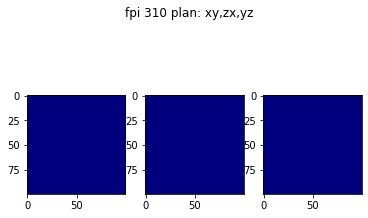

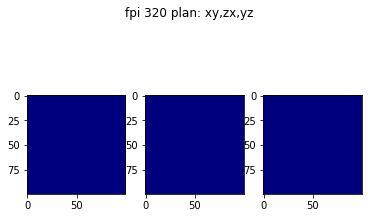

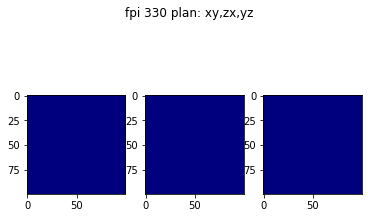

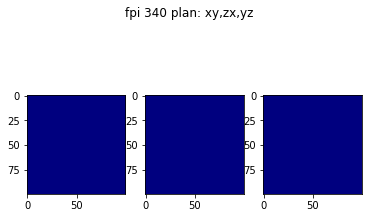

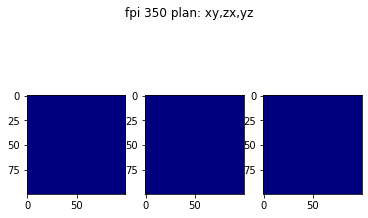

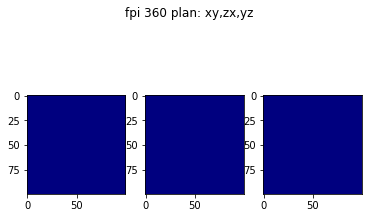

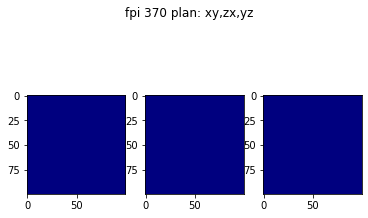

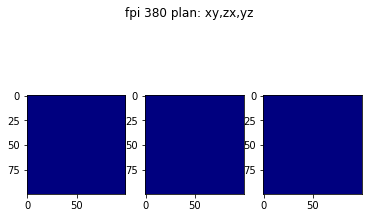

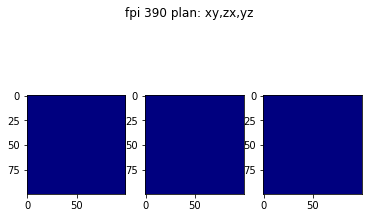

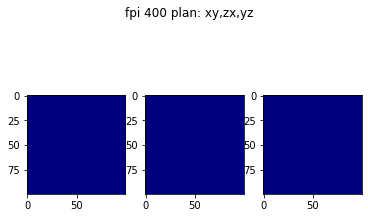

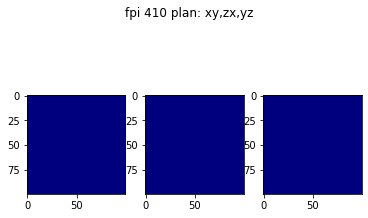

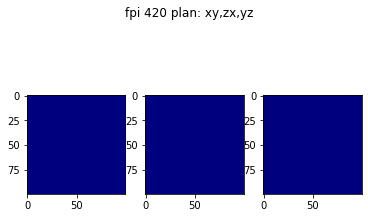

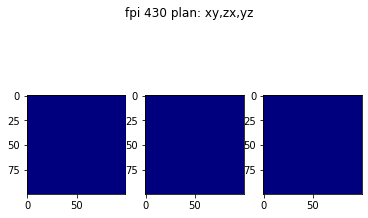

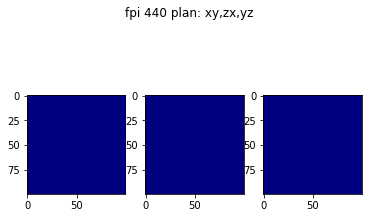

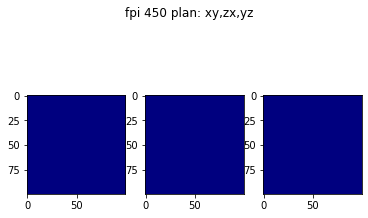

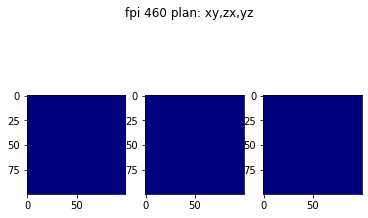

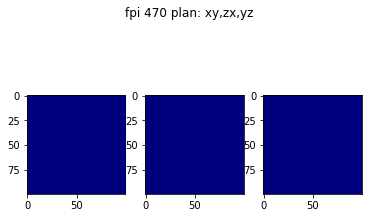

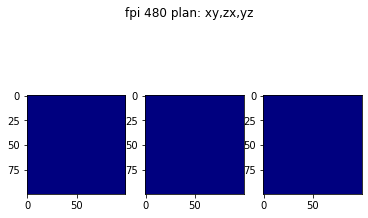

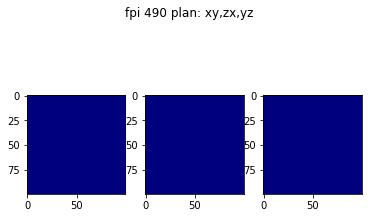

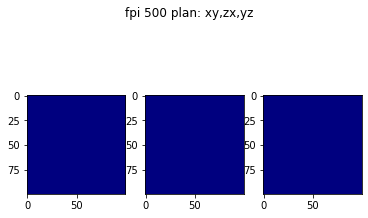

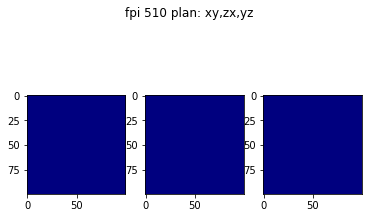

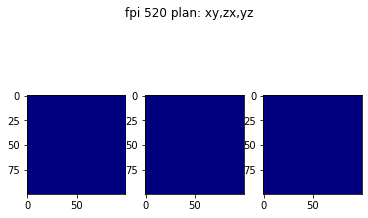

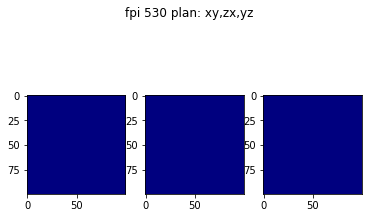

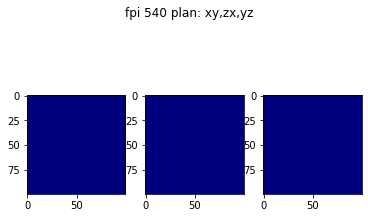

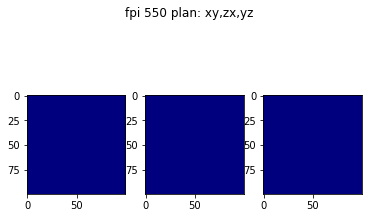

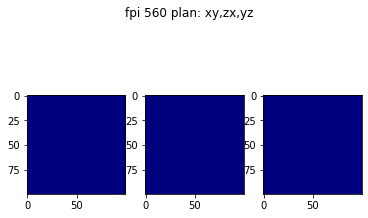

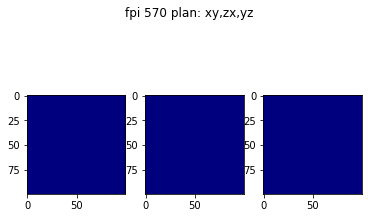

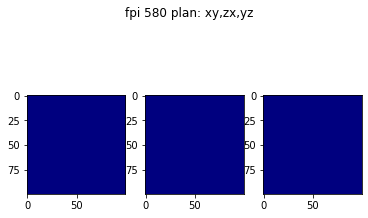

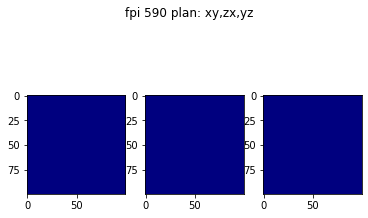

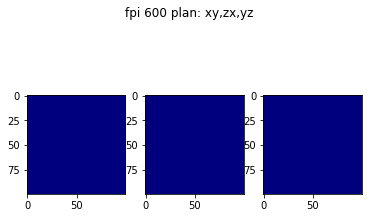

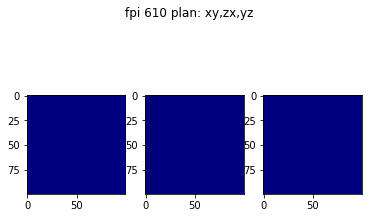

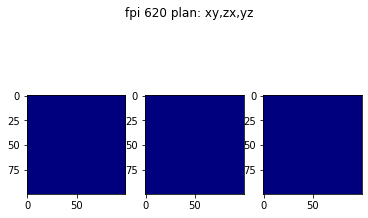

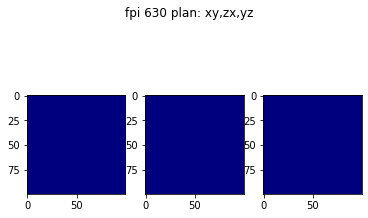

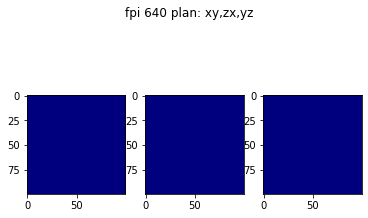

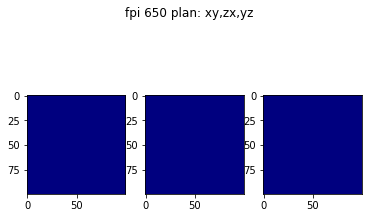

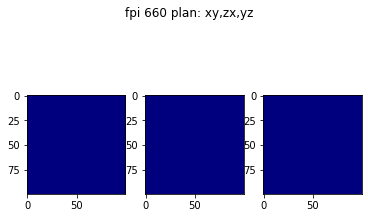

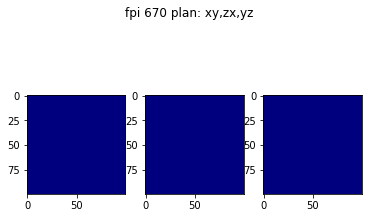

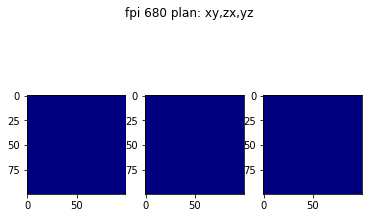

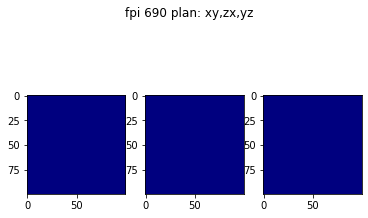

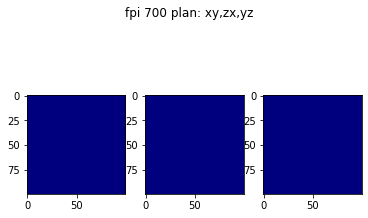

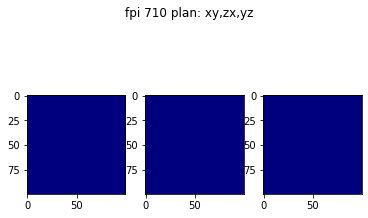

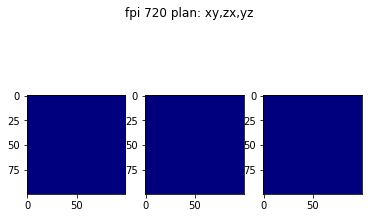

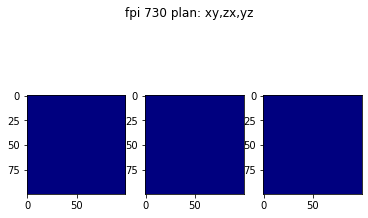

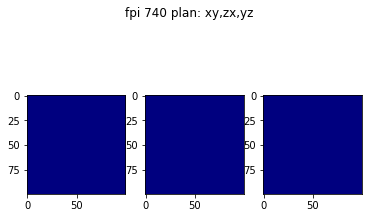

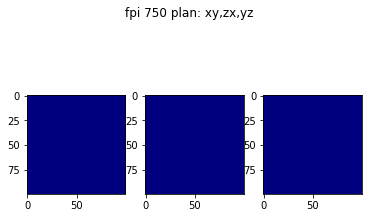

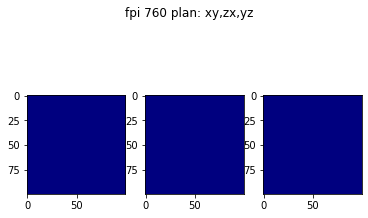

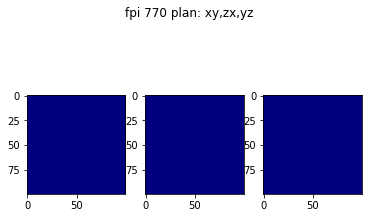

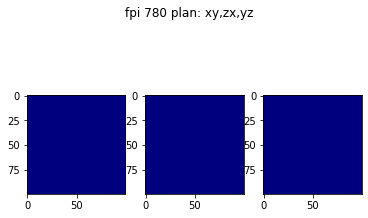

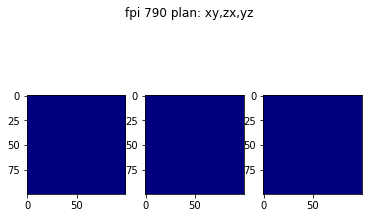

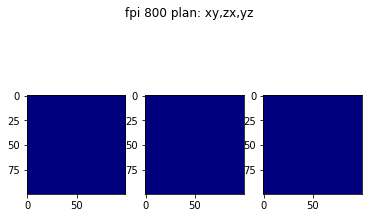

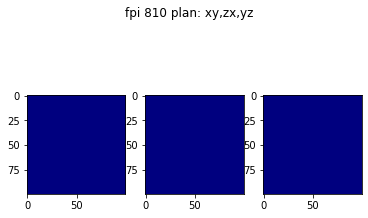

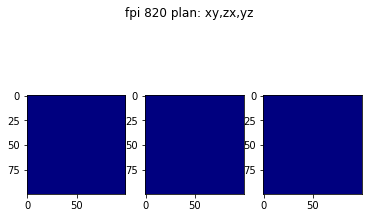

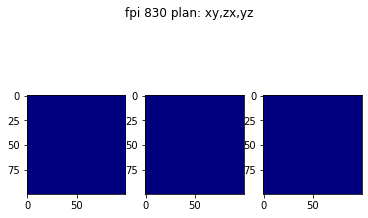

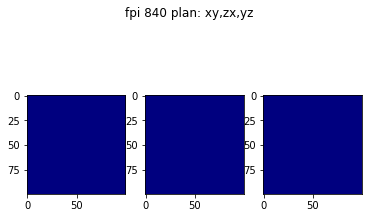

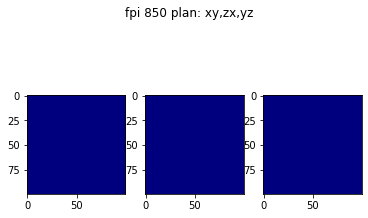

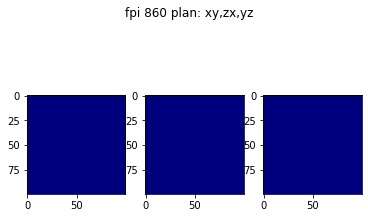

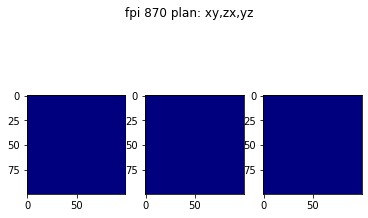

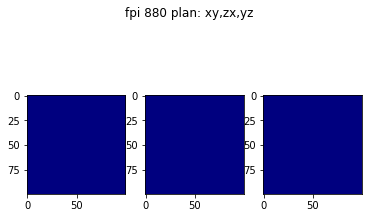

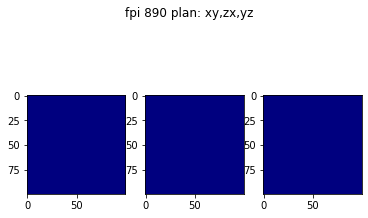

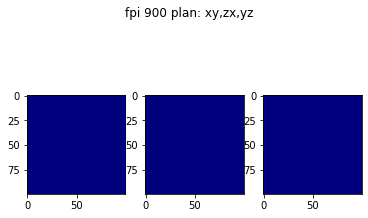

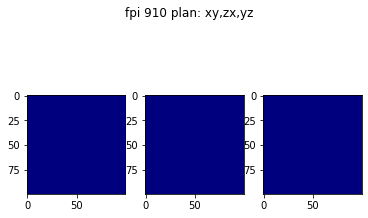

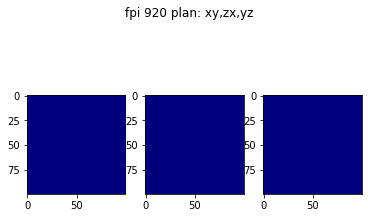

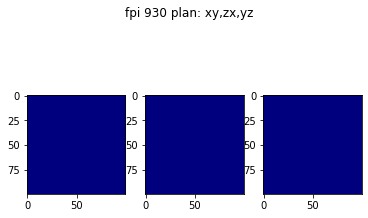

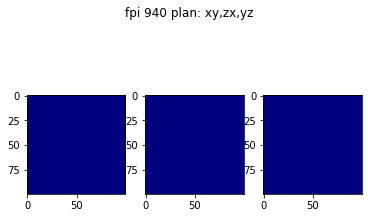

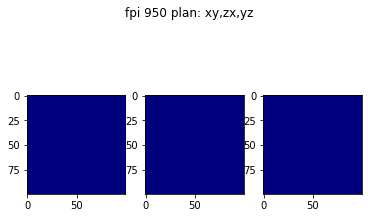

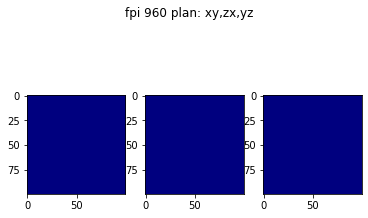

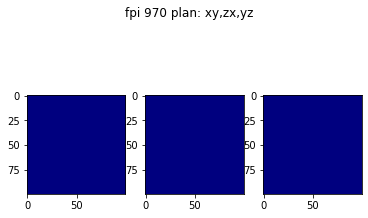

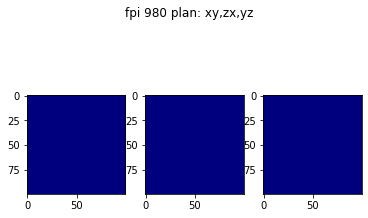

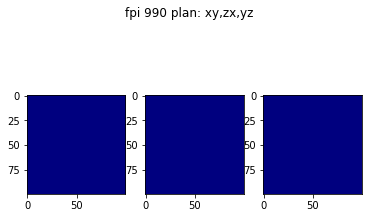

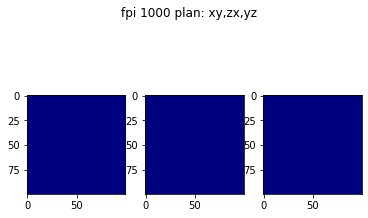

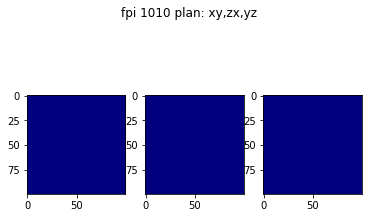

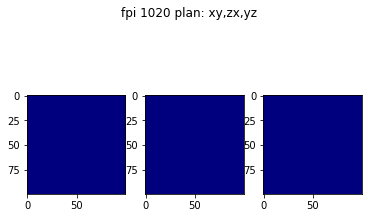

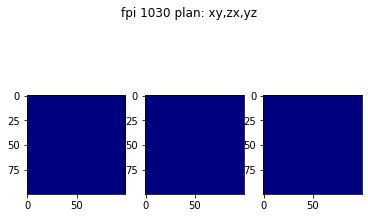

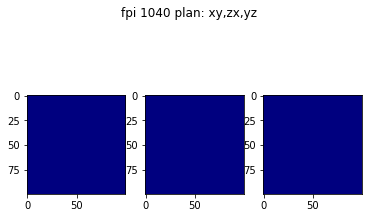

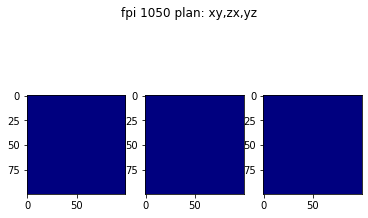

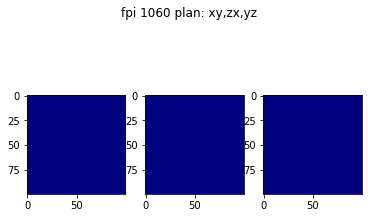

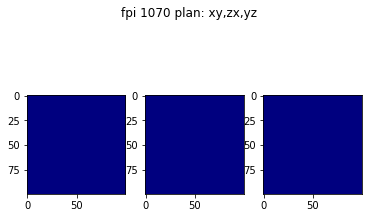

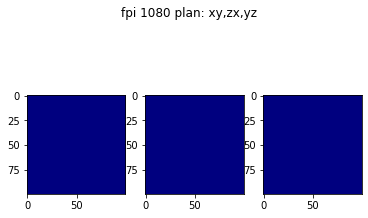

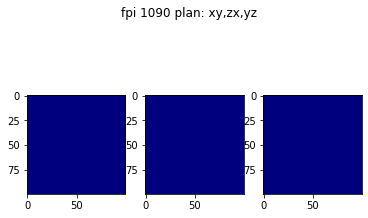

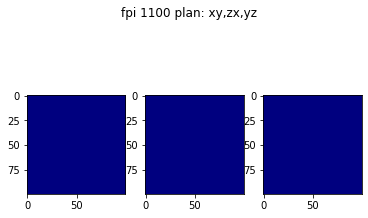

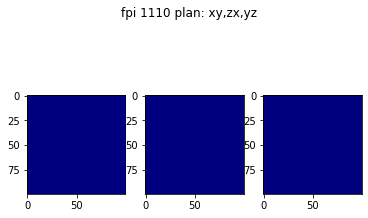

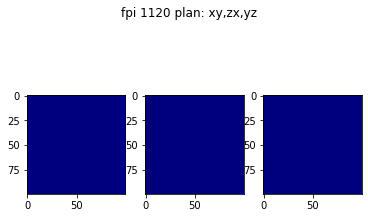

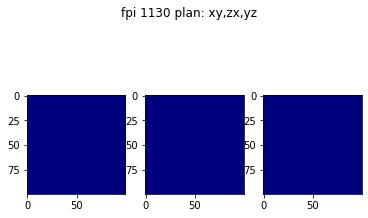

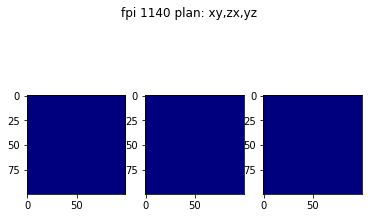

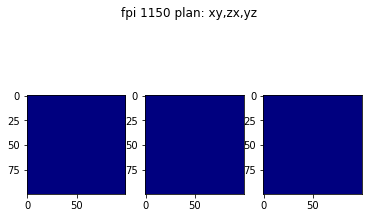

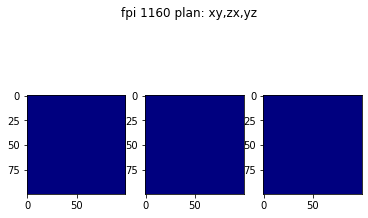

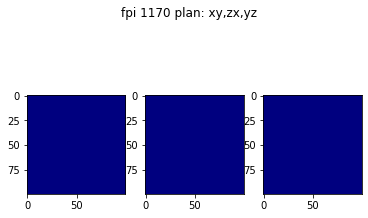

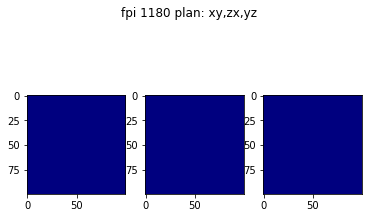

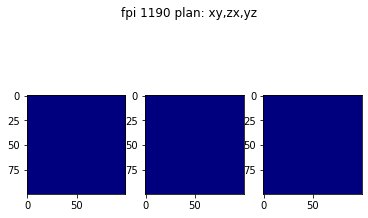

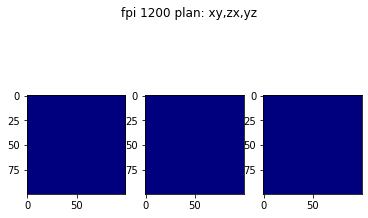

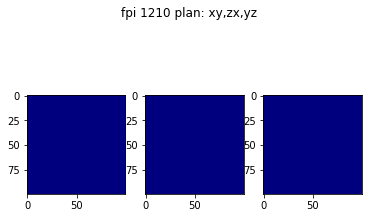

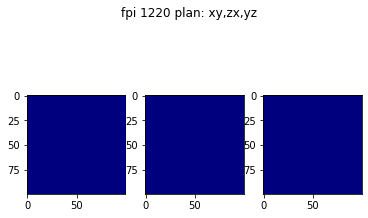

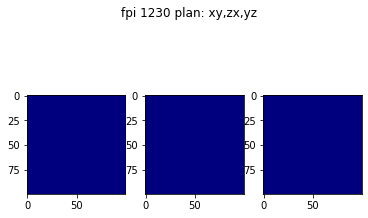

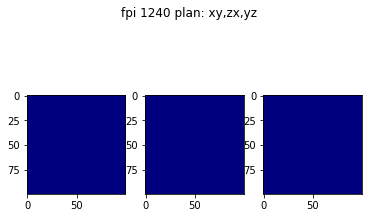

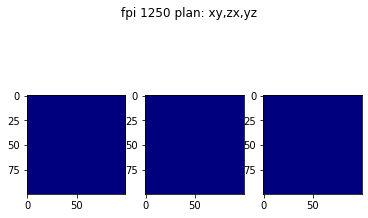

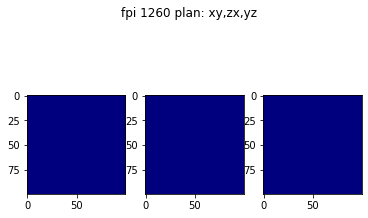

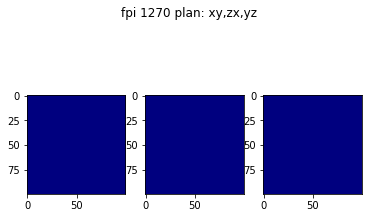

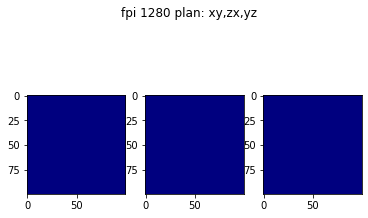

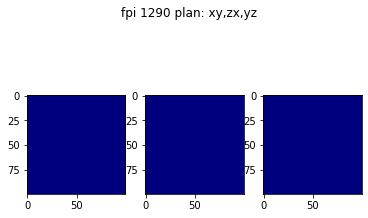

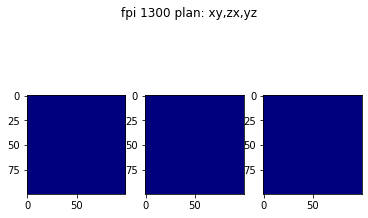

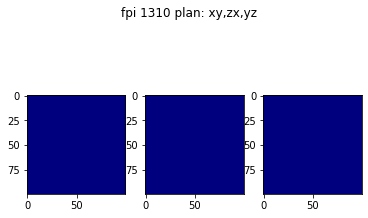

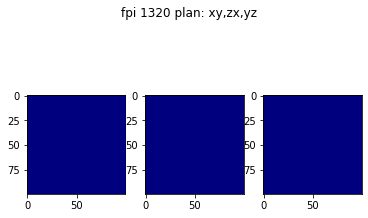

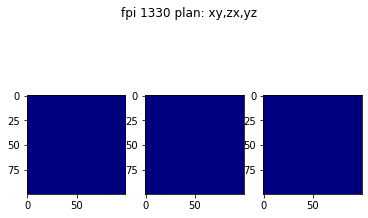

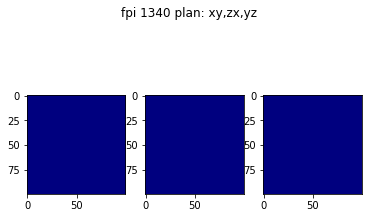

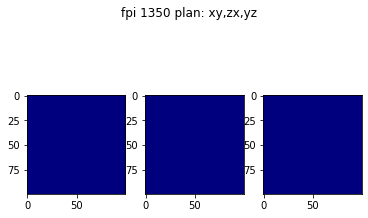

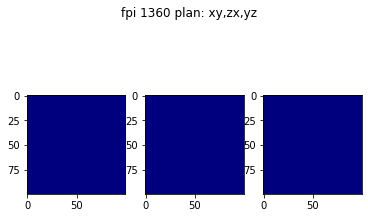

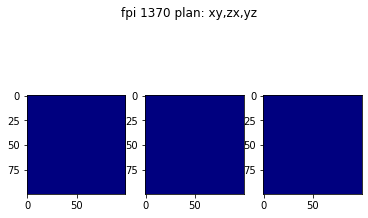

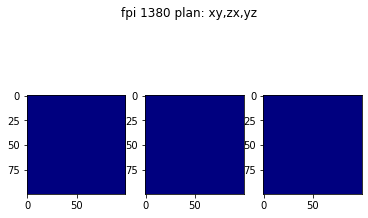

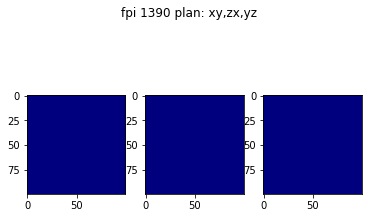

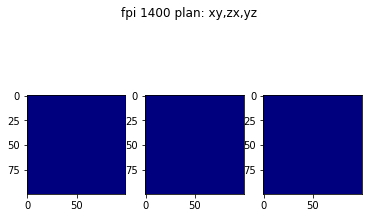

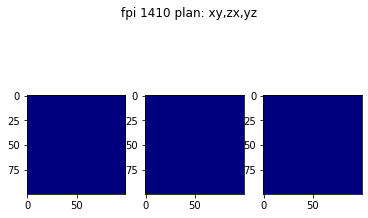

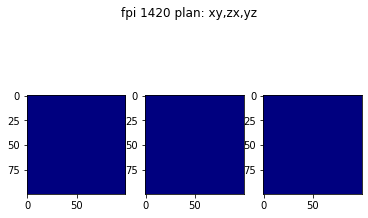

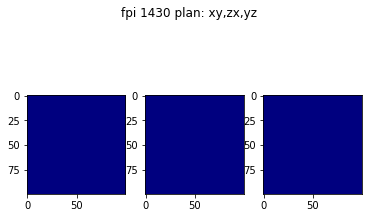

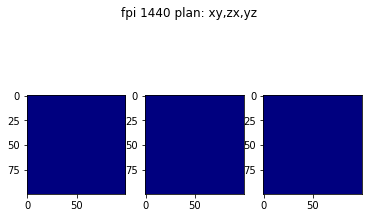

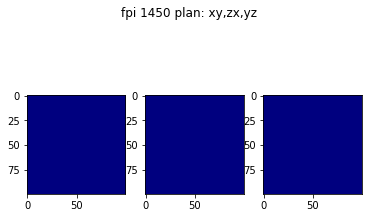

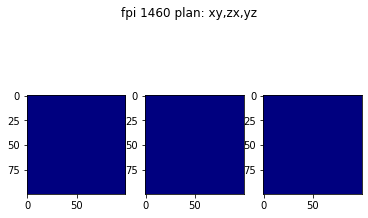

In [10]:
#Code to display VDF crossections if manual interpolation was used

### plot integrating over 1 axis ###
for i in range (0,Ntimes,10):
    fcut=fpicart[i,:,:,:]
    ftot1=np.sum(fcut, axis=0)
    ftot2=np.sum(fcut, axis=1)
    ftot3=np.sum(fcut, axis=2)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle('fpi '+str(i)+' plan: xy,zx,yz')
    ax1.imshow(ftot1, cmap='jet')
    ax2.imshow(ftot2, cmap='jet')
    ax3.imshow(ftot3, cmap='jet')
    #plt.colorbar(scat)

# ax1.axis([20, 80, 20, 80])
# ax2.axis([20, 80, 20, 80])
# ax3.axis([20, 80, 20, 80])

K-means un the generated clusters (Highest silhouette/CH-score determines the optimal number of clsuters)

Text(0, 0.5, 'Calinski-Harabasz-score')

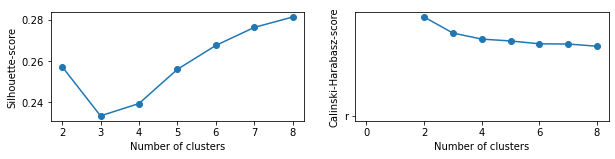

In [37]:
fig.clear()
import sklearn
Sil_Score=[]
CH_score=[]
clusters=list(range(2,9))
from sklearn.cluster import KMeans
for i in range(2,9):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(fcmdata)
    Sil_Score.append(sklearn.metrics.silhouette_score(fcmdata,kmeans.labels_))
    CH_score.append(sklearn.metrics.calinski_harabasz_score(fcmdata,kmeans.labels_))
plt.rcParams['figure.figsize'] = [10, 2]    
  
plt.subplot(1, 2, 1)
plt.plot(clusters,Sil_Score,'-o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette-score')


plt.subplot(1, 2, 2) # index 2

plt.plot(clusters,CH_score,'-o','r')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz-score')


Fuzzy C-means test

In [8]:
fig.clear()
from fcmeans import FCM
n_clusters=4
fcmdata=np.array([xp,yp,zp])
fcmdata=np.conjugate(fcmdata).T
my_model = FCM(n_clusters=n_clusters)
my_model.fit(fcmdata)

fcm_labels = my_model.predict(fcmdata)
fcm_centers = my_model.centers 

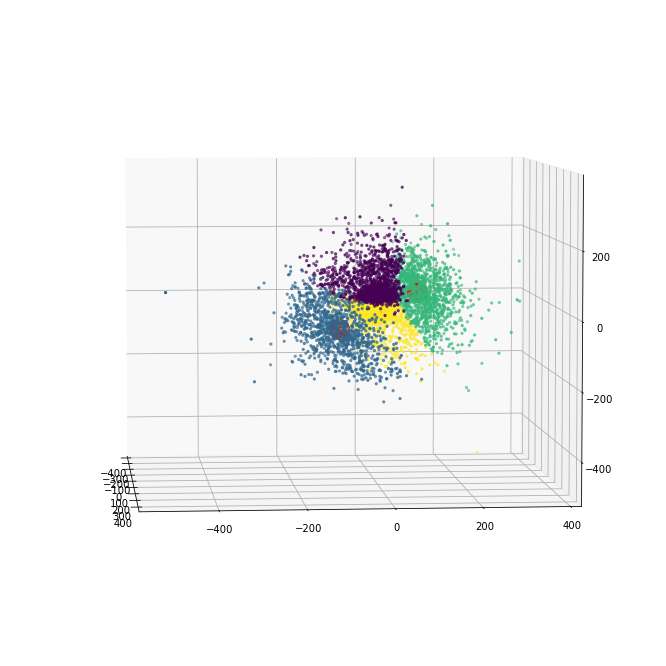

In [9]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(xp,yp,zp,marker='.', c=fcm_labels)
for i in range(0,n_clusters):
    ax.plot(fcm_centers[i,0],fcm_centers[i,1],fcm_centers[i,2],'o', color='red',markersize='20')

for angle in range(0, 360, 5):
    ax.view_init(5, angle)
    display(fig)
    clear_output(wait = True)
    plt.pause(0.1)


Spectral clustering

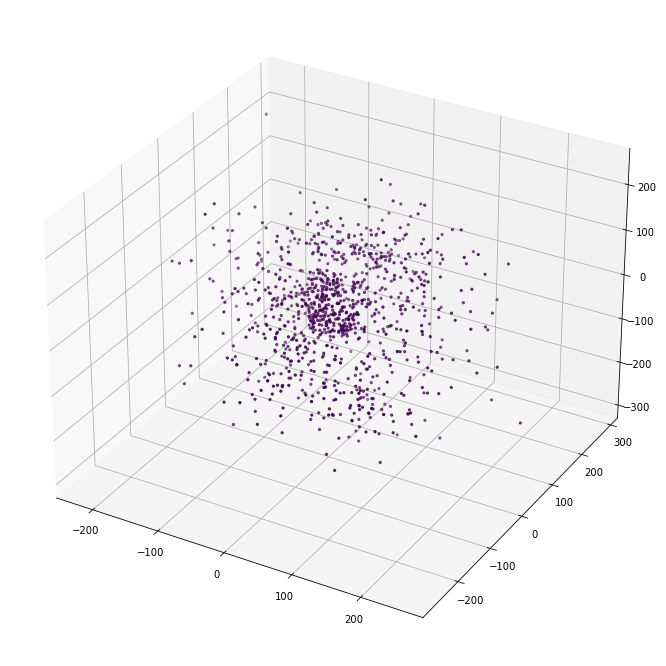

In [12]:
fig.clear()

from sklearn.cluster import SpectralClustering

Sil_Score=[]
CH_score=[]

clusters=list(range(2,10))

for i in range(2,10):
    clustering = SpectralClustering(n_clusters=i,
         assign_labels='discretize', 
        random_state=0,affinity='nearest_neighbors',n_jobs=-1).fit(Xdata)
    Sil_Score.append(sklearn.metrics.silhouette_score(Xdata,clustering.labels_))
    CH_score.append(sklearn.metrics.calinski_harabasz_score(Xdata,clustering.labels_))
plt.rcParams['figure.figsize'] = [10, 2]    
  
plt.subplot(1, 2, 1)
plt.plot(clusters,Sil_Score,'-o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette-score')


plt.subplot(1, 2, 2) # index 2

plt.plot(clusters,CH_score,'-o','r')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz-score')

# for angle in range(0, 360, 5):
#     ax.view_init(5, angle)
#     display(fig)
#     clear_output(wait = True)
#     plt.pause(0.1)


Gaussian Mixture Model with AIC information criterion

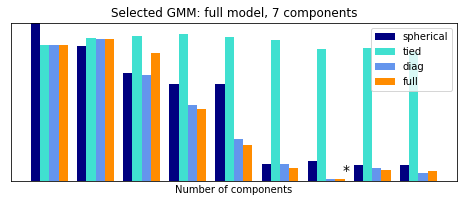

In [11]:
fig.clear()

lowest_aic = np.infty
aic= []
n_components_range= range(1,10)
cv_types = ["spherical","tied","diag","full"]

for cv_type in cv_types:
    for n_components in n_components_range:
    
        gmm = GaussianMixture(n_components,covariance_type=cv_type, random_state=0).fit(fcmdata)
#         gmm_labels=gmm.predict(fcmdata)
        aic.append(gmm.aic(fcmdata))
        if aic[-1] < lowest_aic:
                lowest_aic = aic[-1]
                best_gmm = gmm
aic = np.array(aic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the AIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            aic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([aic.min() * 1.01 - 0.01 * aic.max(), aic.max()])
plt.title("AIC score per model")
xpos = (
    np.mod(aic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(aic.argmin() / len(n_components_range))
)
plt.text(xpos, aic.min() * 0.97 + 0.03 * aic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()

Gaussian Mixture Model with BIC information criterion

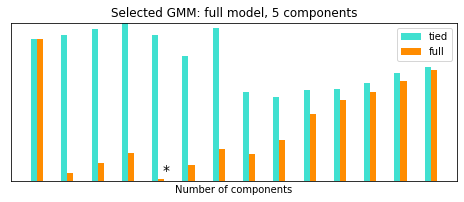

In [33]:
fig.clear()

lowest_bic = np.infty
bic= []
n_components_range= range(1,15)
cv_types = ["tied","full"]

for cv_type in cv_types:
    for n_components in n_components_range:
    
        gmm = GaussianMixture(n_components,covariance_type=cv_type,tol=0.00001, random_state=0).fit(fcmdata)
#         gmm_labels=gmm.predict(fcmdata)
        bic.append(gmm.bic(fcmdata))
        if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
bic = np.array(bic)
color_iter = itertools.cycle(["turquoise", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()

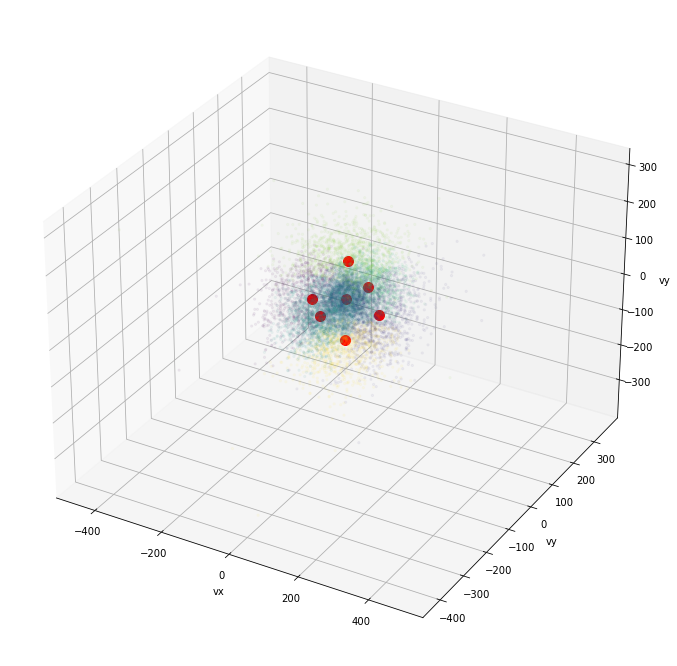

In [14]:
fig.clear()
#Recalculate the labels of the selected model
my_model = GaussianMixture(n_components=best_gmm.n_components,random_state=0,covariance_type='full')
my_model.fit(fcmdata)

gmm_labels = my_model.predict(fcmdata)
gmm_centers = my_model.means_
gmm_labels.shape

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(xp,yp,zp,marker='.', c=gmm_labels,alpha=0.05)

ax.set_xlabel('vx')
ax.set_ylabel('vy')
ax.set_zlabel('vy')

cov=my_model.covariances_

for i in range(0,best_gmm.n_components):
    ax.plot(gmm_centers[i,0],gmm_centers[i,1],gmm_centers[i,2],'o', color='red',markersize='10')

# for angle in range(0, 360, 40):
#     ax.view_init(5, angle)
#     display(fig)
#     clear_output(wait = True)
#     plt.pause(0.1)

DBSCAN

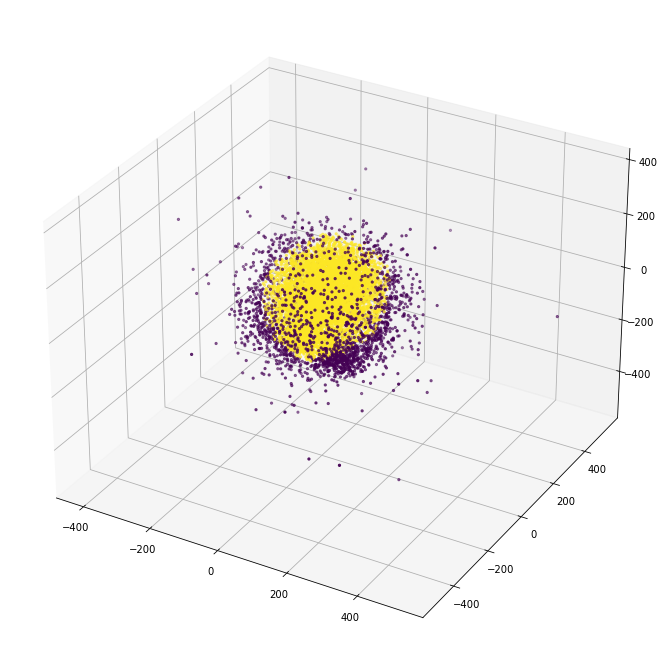

In [53]:
fig.clear()
from sklearn.cluster import DBSCAN
DBcluster = DBSCAN(eps=70, min_samples=500).fit(fcmdata)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(xp,yp,zp,marker='.', c=DBcluster.labels_)



Test Bayesian GMM

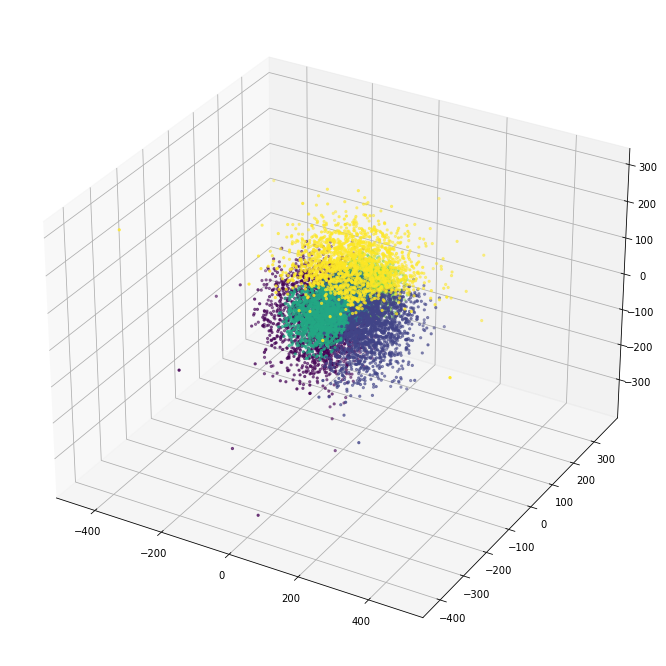

In [15]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=6, random_state=0).fit(fcmdata)
bgm_labels=bgm.predict(fcmdata)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(xp,yp,zp,marker='.', c=bgm_labels)